# Inference from fastq and analysis of prediction probabilities

This notebook provides a reference implementation of the inference applied on k-mer reads, stored in a simple fastq file. It also saves results as a csv file and provides a function to visualize the prediction probabilities.

# 1. Imports and setup environment

In [1]:
# Install required custom packages if not installed yet.
import importlib.util
if not importlib.util.find_spec('ecutilities'):
    print('installing package: `ecutilities`')
    ! pip install -qqU ecutilities
else:
    print('`ecutilities` already installed')
if not importlib.util.find_spec('metagentools'):
    print('installing package: `metagentools')
    ! pip install -qqU metagentools
else:
    print('`metagentools` already installed')

`ecutilities` already installed
`metagentools` already installed


In [2]:
# Import all required packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time

from datetime import datetime
from ecutilities.core import files_in_tree
from ecutilities.ipython import nb_setup
from functools import partial
from IPython.display import display, update_display, Markdown, HTML
from pathlib import Path
from pprint import pprint
from tqdm.notebook import tqdm, trange

# Setup the notebook for development
nb_setup()

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.models import load_model
print(f"Tensorflow version: {tf.__version__}\n")

from metagentools.cnn_virus.data import _base_hot_encode, strings_to_tensors
from metagentools.cnn_virus.data import split_kmer_into_50mers, combine_predictions
from metagentools.cnn_virus.data import FastqFileReader, AlnFileReader
from metagentools.cnn_virus.data import OriginalLabels
from metagentools.cnn_virus.architecture import create_model_original
from metagentools.core import ProjectFileSystem, TextFileBaseReader

Set autoreload mode
Tensorflow version: 2.8.2



List all computing devices available on the machine

In [3]:
devices = device_lib.list_local_devices()
print('\nDevices:')
for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':', 1) for item in name.split(', ')]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', ' ')
    print(f"  - {t}  {d.name} {dev:25s}")


Devices:
  - CPU  /device:CPU:0                          
  - GPU  /device:GPU:0  NVIDIA GeForce GTX 1050 


# 2. Setup paths to files

Key folders and system information

In [4]:
pfs = ProjectFileSystem()
pfs.info()

Running linux on local computer
Device's home directory: /home/vtec
Project file structure:
 - Root ........ /home/vtec/projects/bio/metagentools 
 - Data Dir .... /home/vtec/projects/bio/metagentools/data 
 - Notebooks ... /home/vtec/projects/bio/metagentools/nbs


- `p2model`: path to file with saved original pretrained model
- `p2virus_labels` path to file with virus names and labels mapping for original model

In [5]:
p2model = pfs.data / 'saved/cnn_virus_original/pretrained_model.h5'
assert p2model.is_file(), f"No file found at {p2model.absolute()}"

p2virus_labels = pfs.data / 'CNN_Virus_data/virus_name_mapping'
assert p2virus_labels.is_file(), f"No file found at {p2virus_labels.absolute()}"

p2fastq = pfs.data / 'ncov_data/reads/yf/yf-mapped.fq'
assert p2fastq.is_file(), f"No file found at {p2fastq.absolute()}"

In [6]:
files_in_tree(path=p2fastq.parent);

reads
  |--yf
  |    |--yf-mapped-results-1.csv (0)
  |    |--yf-reads-10.fq (1)
  |    |--yf-mapped.fa (2)
  |    |--yf-mapped.fq (3)


# 3. Load data and review

In [7]:
fastq = FastqFileReader(p2fastq);

/home/vtec/projects/bio/metagentools/metagentools/core.py:498: UserWarning: 
        None of the saved parsing rules were able to extract metadata from the first line in this file.
        You must set a custom rule (pattern + keys) before parsing text, by using:
            `self.set_parsing_rules(custom_pattern, custom_list_of_keys)`
                
  warnings.warn(msg, category=UserWarning)


In [8]:
fastq.reset_iterator()
for i, fq_read in enumerate(fastq):
    seq = fq_read['sequence']
    defline = fq_read['definition line']

print(f"This file includes {i+1:,d} reads, with the following format:\n")
print(f"{defline}\n{seq[:60]} ... ({len(seq)} bp)")

This file includes 11,736 reads, with the following format:

@A00551:791:HFLNGDSX7:1:2247:19289:3270/2
GGCCGATTAAAGTCCGAATTCGGTGGATCACCAGGTGGATGTGTGAGGCCCATGTAGCCC ... (150 bp)


# Prediction Loop (faster batched)

## Define Functions

In [9]:
def base_string_kmers_to_tensors(
    b: tf.Tensor,   # batch of strings 
    k: int = 50     # maximum read length in the batch
    ):
    """Function converting a batch of bp strings into three tensors: (x_seqs, (y_labels, y_pos))"""
    
    # Split the string in three: 
    # returns a ragged tensor which needs to be converted into a normal tensor using .to_tensor()
    t = tf.strings.split(b, '\t').to_tensor(default_value = '', shape=[None, 3])

    # Split each sequence string into a list of single base strings:
    # 'TCAAAATAATCA' -> ['T','C','A','A','A','A','T','A','A','T','C','A']
    seqs = tf.strings.bytes_split(t[:, 0]).to_tensor(shape=(None, k))


    # BHE sequences
    # Each base letter (A, C, G, T, N) is replaced by a OHE vector
    #     "A" converted into [1,0,0,0,0]
    #     "C" converted into [0,1,0,0,0]
    #     "G" converted into [0,0,1,0,0]
    #     "T" converted into [0,0,0,1,0]
    #     "N" converted into [0,0,0,0,1]
    # 
    # Technical Notes:
    # a. The batch of sequence `seqs` has a shape (batch_size, 50) after splitting each byte. 
    #    Must flatten it first, then apply the transform on each base, then reshape to original shape
    # b. We need to map each letter to one vector/tensor. 
    #    1. Cast bytes seqs into integer sequence (uint8 to work byte by byte)
    #    2. For each base letter (A, C, G, T, N) create one tensor (batch_size, 50) (seqs_A, _C, _G, _T, _N)
    #    3. Value is 1 if it is the base in the sequence, otherwise 0
    #    4. Concatenate these 5 tensors into a tensor of shape (batch_size, 50, 5)
 
    seqs_uint8 = tf.io.decode_raw(seqs, out_type=tf.uint8)
    # note: tf.io.decode_raw adds one dimension at the end in the process
    #       [b'C', b'A', b'T'] will return [[67], [65], [84]] and not [67, 65, 84]
    #       this is actually what we want to contatenate the values for each base letter

    A, C, G, T, N = 65, 67, 71, 84, 78

    seqs_A = tf.cast(seqs_uint8 == A, tf.float32)
    seqs_C = tf.cast(seqs_uint8 == C, tf.float32)
    seqs_G = tf.cast(seqs_uint8 == G, tf.float32)
    seqs_T = tf.cast(seqs_uint8 == T, tf.float32)
    seqs_N = tf.cast(seqs_uint8 == N , tf.float32)

    x_seqs = tf.concat([seqs_A, seqs_C, seqs_G, seqs_T, seqs_N], axis=2)

    # OHE labels
    n_labels = 187
    y_labels = tf.strings.to_number(t[:, 1], out_type=tf.int32)
    y_labels = tf.gather(tf.eye(n_labels), y_labels)

    # OHE positions
    n_pos = 10
    y_pos = tf.strings.to_number(t[:, 2], out_type=tf.int32)
    y_pos= tf.gather(tf.eye(n_pos), y_pos)

    return (x_seqs, (y_labels, y_pos))

In [10]:
def split_kmer_batch_into_50mers(
    kmer: tf.Tensor        # tensor representing a batch of k-mer reads, after base encoding
    ):
    """Converts a batch of k-mer reads into several 50-mer reads, by shifting the k-mer one base at a time.

    for a batch of `b` k-mer reads, returns a batch of `b - 49` 50-mer reads
    """
    def fn(accumulated, elem):
        return tf.roll(accumulated, shift=-elem, axis=1)

    b = kmer.shape[0]
    k = kmer.shape[1]
    n = k - 49

    # Create a tensor of integers, with a 0 as first element and 1 for all other elements, for shifts
    shifts = tf.convert_to_tensor([0] + [1] * (n-1))

    # Use tf.scan to shift the original read nb_splits times
    shifted = tf.scan(fn, shifts, kmer, reverse=False)
    # print(shifted.shape)

    # de-interlace the 50-reads
    indices = [(read_nb, batch_nb) for batch_nb in range(b) for read_nb in range(n)]
    shifted = tf.gather_nd(shifted[:, :, :50, :], indices)
    # print(shifted.shape)
    
    # return shifted[:, :50, :]  # return the tensor with shifted kmer, sliced to only keep 50 bases
    return shifted  # return the tensor with shifted kmer, sliced to only keep 50 bases

In [11]:
def combine_label_predictions(probs_elements):
    """???"""

    label_probs = probs_elements[0]
    position_probs = probs_elements[1]

    labels_preds = tf.argmax(label_probs, axis=1)
    positions_preds = tf.argmax(position_probs, axis=1)

    valid_labels_filter = tf.reduce_max(label_probs, axis=1) > 0.9
    valid_labels_preds = labels_preds[valid_labels_filter]
    
    valid_positions_preds = positions_preds[valid_labels_filter]


    if valid_labels_preds.shape[0] == 0:
        combined_label = tf.constant(187, shape=(1,), dtype=tf.int64)
        combined_position = tf.constant(10, shape=(1,), dtype=tf.int64)

    else:
        uniques, _, counts = tf.unique_with_counts(valid_labels_preds)
        combined_label = uniques[tf.argmax(counts)]

        # filter which reads give the majority label prediction
        combined_label_filter = valid_labels_preds == combined_label

        # pick the corresponding position predictions
        filtered_positions = valid_positions_preds[combined_label_filter]
        unique_positions, _, counts = tf.unique_with_counts(filtered_positions)
        combined_position = unique_positions[tf.argmax(counts)]

        combined_pred = tf.concat([combined_label, combined_position], axis=0)

    return combined_pred

In [12]:
def top_predictions(probs, n=3):

    def top_n_most_frequent(preds, n=3):
        """Returns the top n most frequent predictions for each read"""
        # print(preds.shape)
        uniques, counts = np.unique(preds, return_counts=True)
        top_idx = np.argsort(counts)[-n:]
        return uniques.take(top_idx)

    top_preds_in_50mers = np.argsort(probs, axis=-1)[:, :, -n:]
    nb_seq, nb_50mer, nb_lbls = top_preds_in_50mers.shape
    # print(top_preds_in_50mers.shape)
    top_preds_in_kmer = top_preds_in_50mers.reshape(nb_seq,nb_50mer * nb_lbls)
    # print(top_preds_in_kmer.shape)

    return np.apply_along_axis(top_n_most_frequent, axis=1, arr=top_preds_in_kmer, n=n)

# top_predictions(label_probs_per_kmer, n=3)

In [13]:
fastq = FastqFileReader(p2fastq);

In [14]:
nb_reads = 0
k = 150
n = k - 49

fastq.reset_iterator()
strings = []
max_length = 0
for i,fqelement in enumerate(fastq):
    seq = fqelement['sequence'][:k]
    strings.append(f"{seq}\t0\t0")
    if len(seq) > max_length: max_length = len(seq)
    if nb_reads != 0 and i >= nb_reads-1: break

print(f"This file includes {i+1:,d} reads, with the following format (max length: {max_length} bp):\n")
print(f"{defline}\n{seq[:60]} ... ({len(seq)} bp)")

This file includes 11,736 reads, with the following format (max length: 150 bp):

@A00551:791:HFLNGDSX7:1:2247:19289:3270/2
GGCCGATTAAAGTCCGAATTCGGTGGATCACCAGGTGGATGTGTGAGGCCCATGTAGCCC ... (150 bp)


## Run the Loop

Before running the next cell, define:
- size of the batch `b`
- the number of bp in a k-mer
- the number n for top-n predictions to save
- whether to run the full loop or only a few batches

In [24]:
b = 1024      # number of k-mer in a batch
k = 150
top_n = 5   # n for top-n prediction to keep
run_all_batches = True
nb_batches_to_run = 3

p2results = p2fastq.parent / f"{p2fastq.stem}-results.csv"

nb_50mer = k - 49
print(f"Run prediction loop with the following parameters:")
print(f"   {b} k-mer per batch; {k} bp per sequence; keep top-{top_n} predictions")

fastq.reset_iterator()
model = create_model_original(path2parameters=p2model)

# create a dataframe to store results
pred_cols = ['lbl_pred','pos_pred']
top_pred_cols = [f"top_{top_n}_lbl_pred_{i}" for i in range(top_n)]
prob_cols = [f"R{i}ProbL{j}" for i in range(k-49) for j in range(187)]
df = pd.DataFrame(
    columns=pred_cols + top_pred_cols + prob_cols,
    dtype=float
)

df.to_csv(p2results)
print(f"results will be saved to {p2results.absolute()}")

batch_seq_strings = []
batch_seq_refs = []
batch_nb = 1
print(f"Batch {batch_nb:3d} ...")
load_seq_starts = time.time()

for i,fqelement in enumerate(fastq):
    seq = fqelement['sequence'][:k]
    batch_seq_strings.append(f"{seq}\t0\t0")
    batch_seq_refs.append(fqelement['definition line'])
 
    # After reading b sequences from the fq file, make a prediction and load results in a dataframe
    if (i+1) % b == 0:
        pred_starts = time.time()
        print(f"   {b} sequences loaded in {time.time() - load_seq_starts:.2f} s")
        print(f"   prediction for batch {int((i+1)/b)} starting ...")
        # Prediction
        strings_ts = tf.convert_to_tensor(batch_seq_strings)
        seqs_kmer, (labels, positions) = base_string_kmers_to_tensors(strings_ts, k)
        seqs_50mer = split_kmer_batch_into_50mers(seqs_kmer)
        labels_probs, positions_probs = model.predict(seqs_50mer)
        label_probs_per_kmer = tf.reshape(labels_probs, shape=(b,nb_50mer,-1))
        position_probs_per_kmer = tf.reshape(positions_probs, shape=(b,nb_50mer,-1))
        combined_predictions = tf.map_fn(
            fn=combine_label_predictions, 
            elems=[label_probs_per_kmer, position_probs_per_kmer], 
            fn_output_signature=tf.int64
            )
        label_predictions = combined_predictions[:,0]
        position_predictions = combined_predictions[:,1]

        # Add results for batch
        top_preds = top_predictions(label_probs_per_kmer, n=top_n)
        res = np.concatenate(
            [
                np.expand_dims(label_predictions.numpy(), axis=1),
                np.expand_dims(position_predictions.numpy(), axis=1),
                top_preds[:, ::-1],
                label_probs_per_kmer.numpy().reshape(b, -1)
            ],
            axis=1
            )
        # df = pd.concat([df, pd.DataFrame(res, index=batch_seq_refs, columns=df.columns)], ignore_index=False)
        df = pd.DataFrame(res, index=batch_seq_refs, columns=df.columns)
        df.to_csv(p2results, mode='a', header=False)

        # Reset batch
        batch_seq_strings = []
        batch_seq_refs = []
        print(f"   prediction done in {time.time() - pred_starts:.2f} s")
        batch_nb += 1
        print(f"Batch {batch_nb:3d} ...")
        load_seq_starts = time.time()

    # Stop after a few batches
    if not run_all_batches and (i+1) >= b * nb_batches_to_run: 
        break

print('Done')
print(f"Predicted virus class for {df.shape[0]} {k}-mer sequences")

Run prediction loop with the following parameters:
   1024 k-mer per batch; 150 bp per sequence; keep top-5 predictions
Creating CNN Model (Original)
Loading parameters from pretrained_model.h5
Created pretrained model
results will be saved to /home/vtec/projects/bio/metagentools/data/ncov_data/reads/yf/yf-mapped-results.csv
Batch   1 ...
   1024 sequences loaded in 0.05 s
   prediction for batch 1 starting ...
   prediction done in 116.16 s
Batch   2 ...
   1024 sequences loaded in 0.07 s
   prediction for batch 2 starting ...
   prediction done in 114.01 s
Batch   3 ...
   1024 sequences loaded in 0.06 s
   prediction for batch 3 starting ...
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/vtec/miniconda3/envs/metagentools/lib/python3.10/site-packages/tensorflow/python/ops/control_flo

# Analyse prediction probabilities

## Define functions

In [32]:
def plot_label_probs(probs, top_preds, targets):
    nb_seq, _ , nb_lbls = probs.shape
    assert nb_lbls == 187
    fig = plt.figure(figsize=(16, 2 * nb_seq - 1));
    # fig.suptitle('Suptitle')
    axs = []
    for i in range(nb_seq):
        if top_preds[i, 0] in targets: cmap = 'YlGn_r'
        else: cmap = 'YlOrRd_r'
        axs.append(plt.subplot2grid((nb_seq,1), (i,0), rowspan=1, colspan=1))
        # axs[i].axis('off')
        axs[i].imshow(probs[i,:,:], cmap=cmap, aspect='auto')
        axs[i].set_title(f"Seq {i+1} - Pred: {top_preds[i,0]} - Top Predictions; {top_preds[i]}")

    fig.subplots_adjust(top=1.5, bottom=0.2, hspace=0.5)
    plt.show()

## Handle entire result file

Next cell load the entire result file. It takes a while to load.

If the file is too big, it may fail. In that case, load the file in chunks and handle each chunck separately (see lower cells).

In [26]:
p2resfile = pfs.project_root /'data/ncov_data/reads/yf/yf-mapped-results.csv'

df = pd.read_csv(p2resfile, index_col=0)
df.head()

lbl_pred  pos_pred  \
@A00551:791:HFLNGDSX7:1:2427:6262:35321/2      118.0       0.0   
@A00551:791:HFLNGDSX7:1:2427:6180:35368/2      118.0       0.0   
@A00551:791:HFLNGDSX7:1:2428:6406:5353/2       118.0       0.0   
@A00551:791:HFLNGDSX7:1:1124:13404:31062/1     118.0       0.0   
@A00551:791:HFLNGDSX7:1:1357:2465:18443/1      118.0       0.0   

                                            top_5_lbl_pred_0  \
@A00551:791:HFLNGDSX7:1:2427:6262:35321/2              118.0   
@A00551:791:HFLNGDSX7:1:2427:6180:35368/2              118.0   
@A00551:791:HFLNGDSX7:1:2428:6406:5353/2               118.0   
@A00551:791:HFLNGDSX7:1:1124:13404:31062/1             118.0   
@A00551:791:HFLNGDSX7:1:1357:2465:18443/1              118.0   

                                            top_5_lbl_pred_1  \
@A00551:791:HFLNGDSX7:1:2427:6262:35321/2               19.0   
@A00551:791:HFLNGDSX7:1:2427:6180:35368/2               19.0   
@A00551:791:HFLNGDSX7:1:2428:6406:5353/2                19.0   
@A00551:791:HFLNGDSX7:1:1124:13404:31062/1               4.0   
@A00551:791:HFLNGDSX7:1:1357:2465:18443/1                0.0   

                                            top_5_lbl_pred_2  \
@A00551:791:HFLNGDSX7:1:2427:6262:35321/2                9.0   
@A00551:791:HFLNGDSX7:1:2427:6180:35368/2                9.0   
@A00551:791:HFLNGDSX7:1:2428:6406:5353/2                 9.0   
@A00551:791:HFLNGDSX7:1:1124:13404:31062/1              12.0   
@A00551:791:HFLNGDSX7:1:1357:2465:18443/1               18.0   

                                            top_5_lbl_pred_3  \
@A00551:791:HFLNGDSX7:1:2427:6262:35321/2                0.0   
@A00551:791:HFLNGDSX7:1:2427:6180:35368/2                0.0   
@A00551:791:HFLNGDSX7:1:2428:6406:5353/2                 0.0   
@A00551:791:HFLNGDSX7:1:1124:13404:31062/1               0.0   
@A00551:791:HFLNGDSX7:1:1357:2465:18443/1              108.0   

                                            top_5_lbl_pred_4      R0ProbL0  \
@A00551:791:HFLNGDSX7:1:2427:6262:35321/2              109.0  1.378078e-08   
@A00551:791:HFLNGDSX7:1:2427:6180:35368/2              109.0  1.378078e-08   
@A00551:791:HFLNGDSX7:1:2428:6406:5353/2               109.0  1.378078e-08   
@A00551:791:HFLNGDSX7:1:1124:13404:31062/1              20.0  2.881920e-09   
@A00551:791:HFLNGDSX7:1:1357:2465:18443/1                5.0  5.053398e-12   

                                                R0ProbL1      R0ProbL2  ...  \
@A00551:791:HFLNGDSX7:1:2427:6262:35321/2   2.271862e-12  6.251460e-11  ...   
@A00551:791:HFLNGDSX7:1:2427:6180:35368/2   2.271862e-12  6.251460e-11  ...   
@A00551:791:HFLNGDSX7:1:2428:6406:5353/2    2.271862e-12  6.251460e-11  ...   
@A00551:791:HFLNGDSX7:1:1124:13404:31062/1  5.976309e-18  1.272364e-04  ...   
@A00551:791:HFLNGDSX7:1:1357:2465:18443/1   1.587486e-19  6.788127e-09  ...   

                                            R100ProbL177  R100ProbL178  \
@A00551:791:HFLNGDSX7:1:2427:6262:35321/2   1.243842e-09  5.060352e-13   
@A00551:791:HFLNGDSX7:1:2427:6180:35368/2   1.243842e-09  5.060352e-13   
@A00551:791:HFLNGDSX7:1:2428:6406:5353/2    1.243842e-09  5.060352e-13   
@A00551:791:HFLNGDSX7:1:1124:13404:31062/1  2.366665e-05  1.799163e-15   
@A00551:791:HFLNGDSX7:1:1357:2465:18443/1   2.096878e-11  3.203865e-10   

                                            R100ProbL179  R100ProbL180  \
@A00551:791:HFLNGDSX7:1:2427:6262:35321/2   2.177048e-10  5.206338e-16   
@A00551:791:HFLNGDSX7:1:2427:6180:35368/2   2.177048e-10  5.206338e-16   
@A00551:791:HFLNGDSX7:1:2428:6406:5353/2    2.177048e-10  5.206338e-16   
@A00551:791:HFLNGDSX7:1:1124:13404:31062/1  8.427831e-11  3.449799e-12   
@A00551:791:HFLNGDSX7:1:1357:2465:18443/1   9.391163e-13  3.125100e-08   

                                            R100ProbL181  R100ProbL182  \
@A00551:791:HFLNGDSX7:1:2427:6262:35321/2   5.367420e-11  7.828192e-11   
@A00551:791:HFLNGDSX7:1:2427:6180:35368/2   5.367420e-11  7.828192e-11   
@A00551:791:HFLNGDSX7:1:2428:6406:5353/2    5.36742

In [33]:
probs_per_kmer = df[prob_cols].to_numpy().reshape(df.shape[0], -1, 187)
top_preds = df[top_pred_cols].to_numpy()
preds = top_preds[:, 0]

In [34]:
correct_pred_idxs = preds == 118
incorrect_pred_idxs = preds != 118
true_positives = correct_pred_idxs.sum()
false_negatives = incorrect_pred_idxs.sum()
accuracy = true_positives/(true_positives + false_negatives)
print(f"True positives:  {true_positives}")
print(f"False negatives: {false_negatives}")
print(f"Accuracy:        {accuracy:.2%}")

True positives:  1560
False negatives: 9704
Accuracy:        13.85%


### Plot prediction probabilities

#### Mixed predictions

Show profile of 101 label probabilities of each 50-mer corresponding to a k-mer read

There are about 17k reads, do not use this function for more than 50 reads at the time

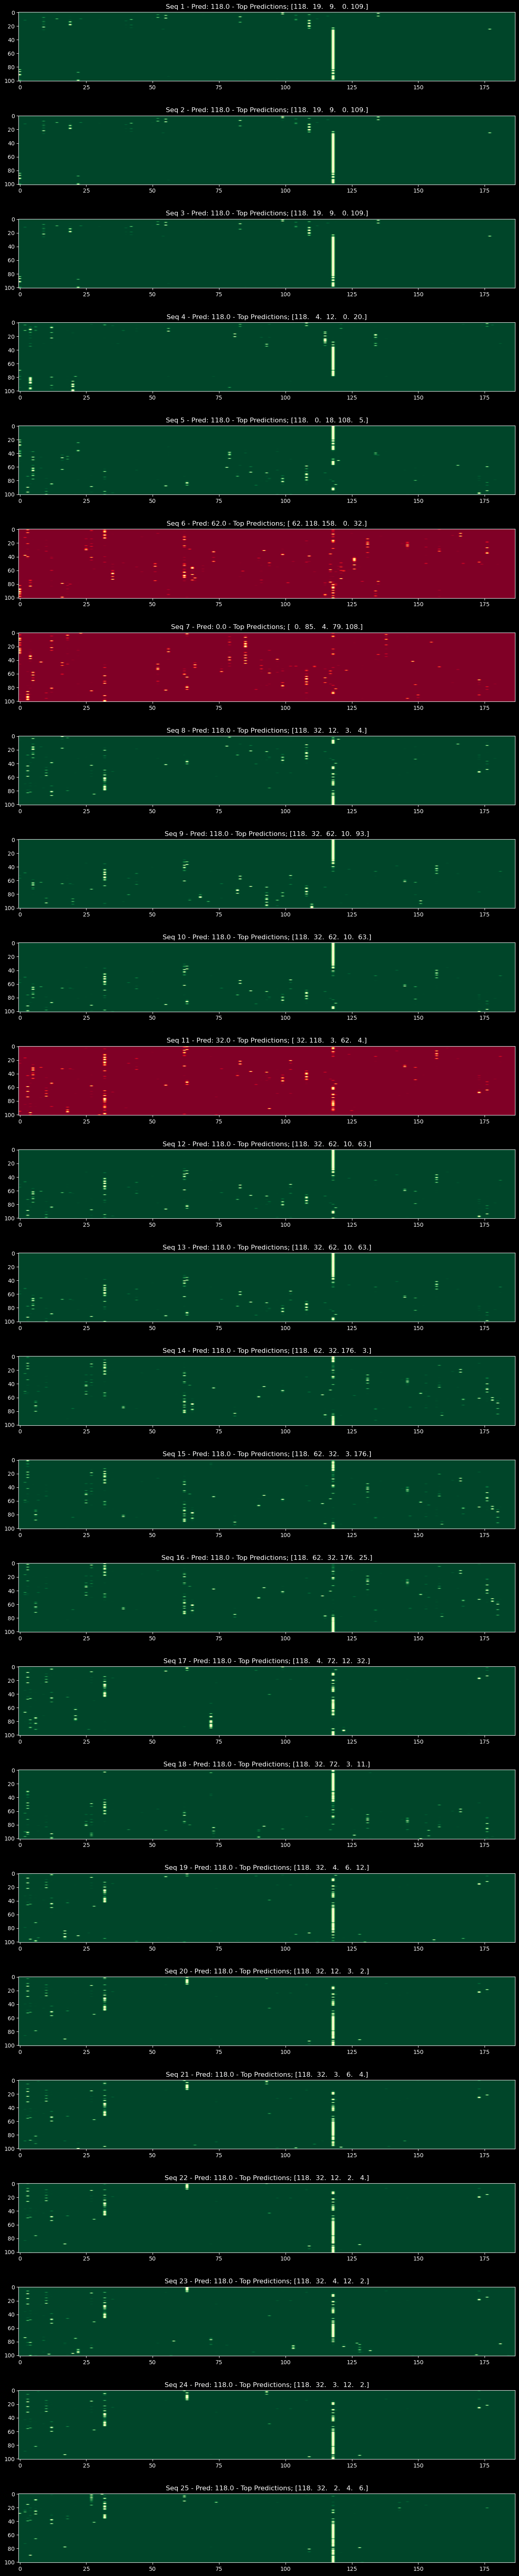

In [35]:
first_seq = 0
nb_seq = 25
s = slice(first_seq, first_seq+nb_seq)

plot_label_probs(probs_per_kmer[s,:,:], top_preds[s], [118])

#### True Positive Only

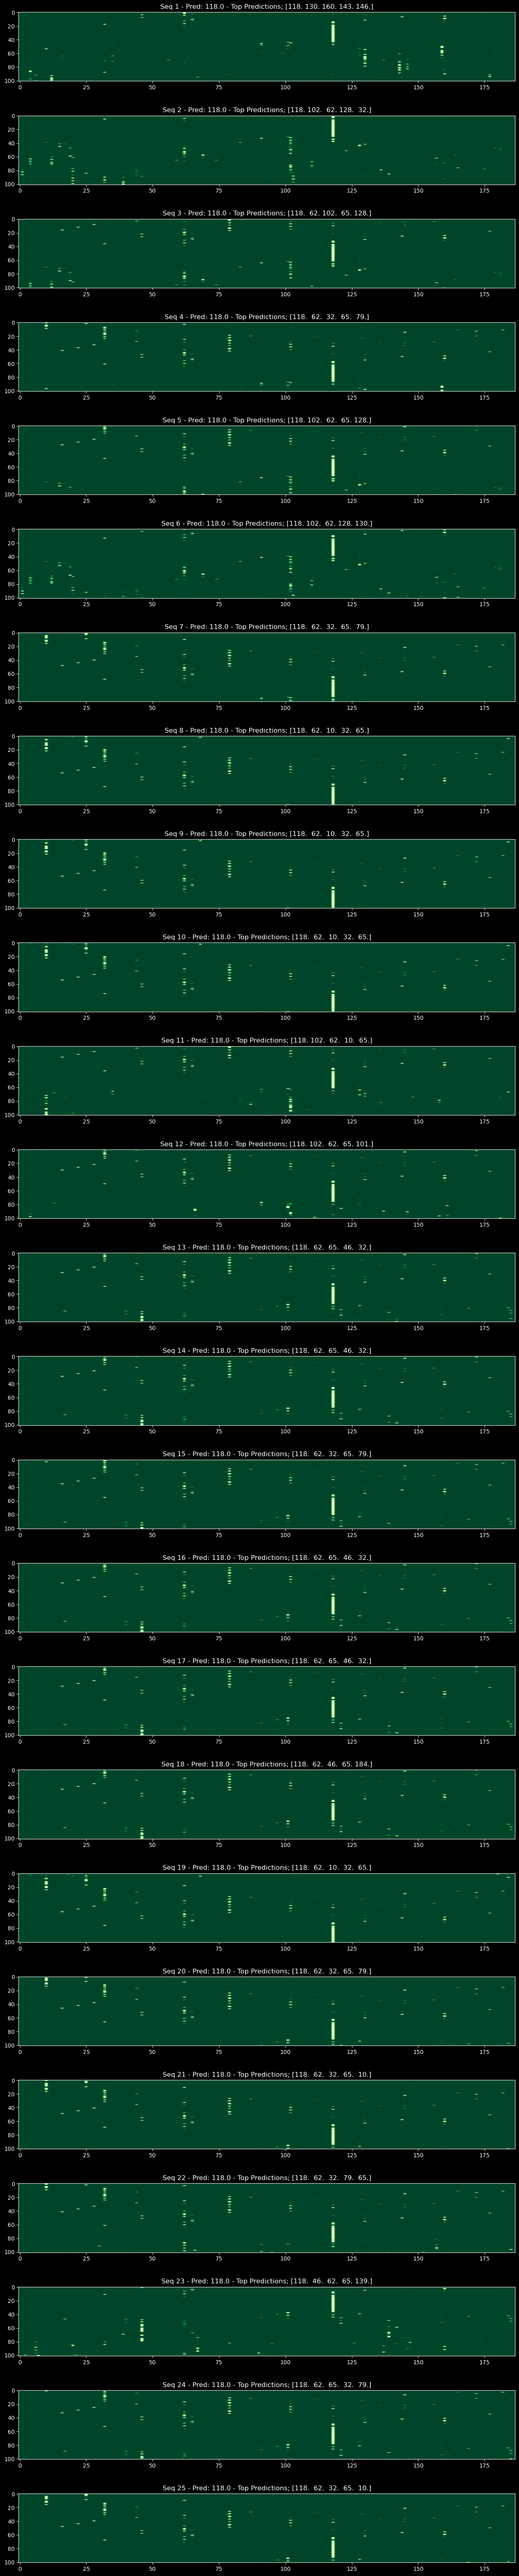

In [36]:
first_seq = 1000
nb_seq = 25
s = slice(first_seq, first_seq+nb_seq)

plot_label_probs(probs_per_kmer[correct_pred_idxs][s,:,:], top_preds[correct_pred_idxs][s], [118])

#### False Positive Only

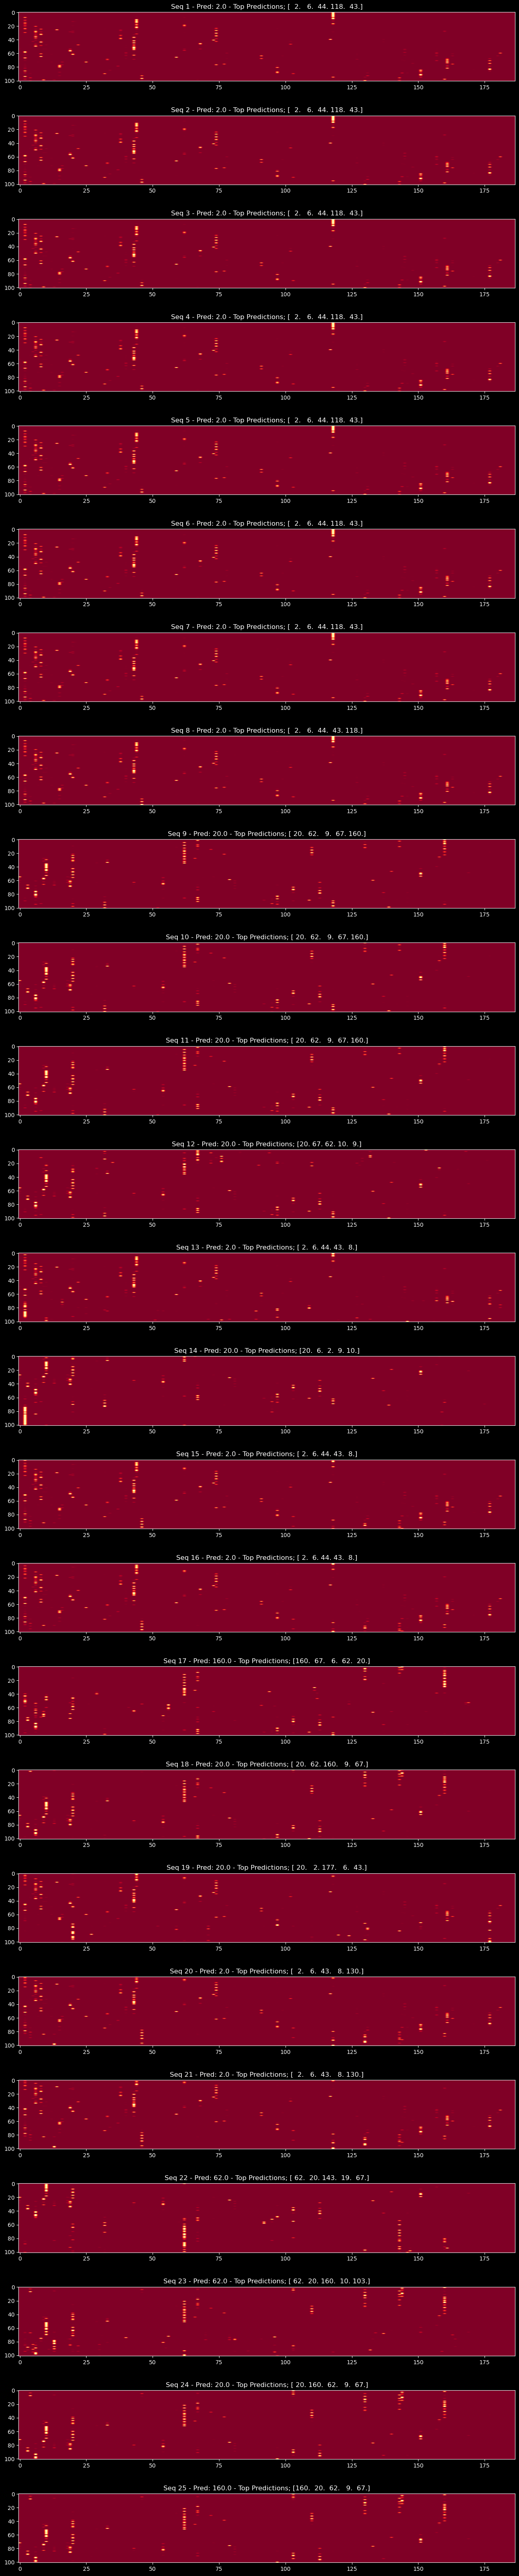

In [37]:
first_seq = 1000
nb_seq = 25
s = slice(first_seq, first_seq+nb_seq)

plot_label_probs(probs_per_kmer[incorrect_pred_idxs][s,:,:], top_preds[incorrect_pred_idxs][s], [118])

## Load result in chunks

In [53]:
p2resfile = pfs.project_root /'data/ncov_data/reads/yf/yf-mapped-results.csv'

def result_generator(p2file, chunksize=1000):
    for chunk in pd.read_csv(p2file, chunksize=chunksize, index_col=0):
        yield chunk

def get_chunk(p2file, chunknb, chunksize=1000):
    gen = result_generator(p2file, chunksize=chunksize)
    for i in range(chunknb):
        df = next(gen)
    return df

In [57]:
chunk = get_chunk(p2resfile, chunknb=4, chunksize=1000)
chunk.shape

(1000, 18894)

In [58]:
probs_per_kmer = chunk[prob_cols].to_numpy().reshape(chunk.shape[0], -1, 187)
top_preds = chunk[top_pred_cols].to_numpy()
preds = top_preds[:, 0]

In [59]:
correct_pred_idxs = preds == 118
incorrect_pred_idxs = preds != 118
true_positives = correct_pred_idxs.sum()
false_negatives = incorrect_pred_idxs.sum()
accuracy = true_positives/(true_positives + false_negatives)
print(f"True positives:  {true_positives}")
print(f"False negatives: {false_negatives}")
print(f"Accuracy:        {accuracy:.2%}")

True positives:  6
False negatives: 994
Accuracy:        0.60%


#### Mixed Predictions

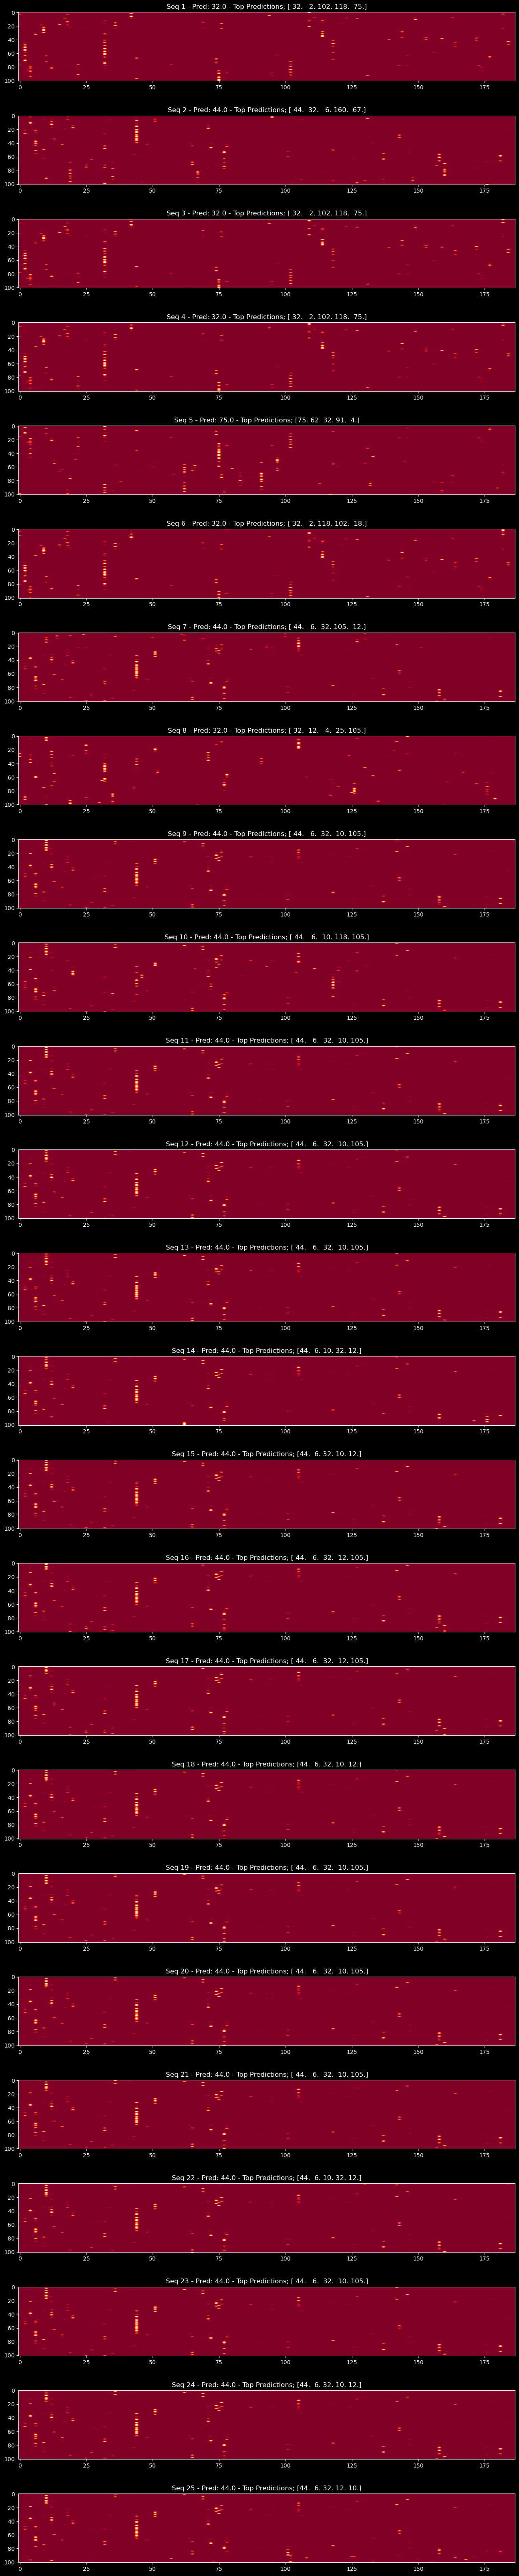

In [60]:
first_seq = 0
nb_seq = 25
s = slice(first_seq, first_seq+nb_seq)

plot_label_probs(probs_per_kmer[s,:,:], top_preds[s], [118])

#### True Positive Only

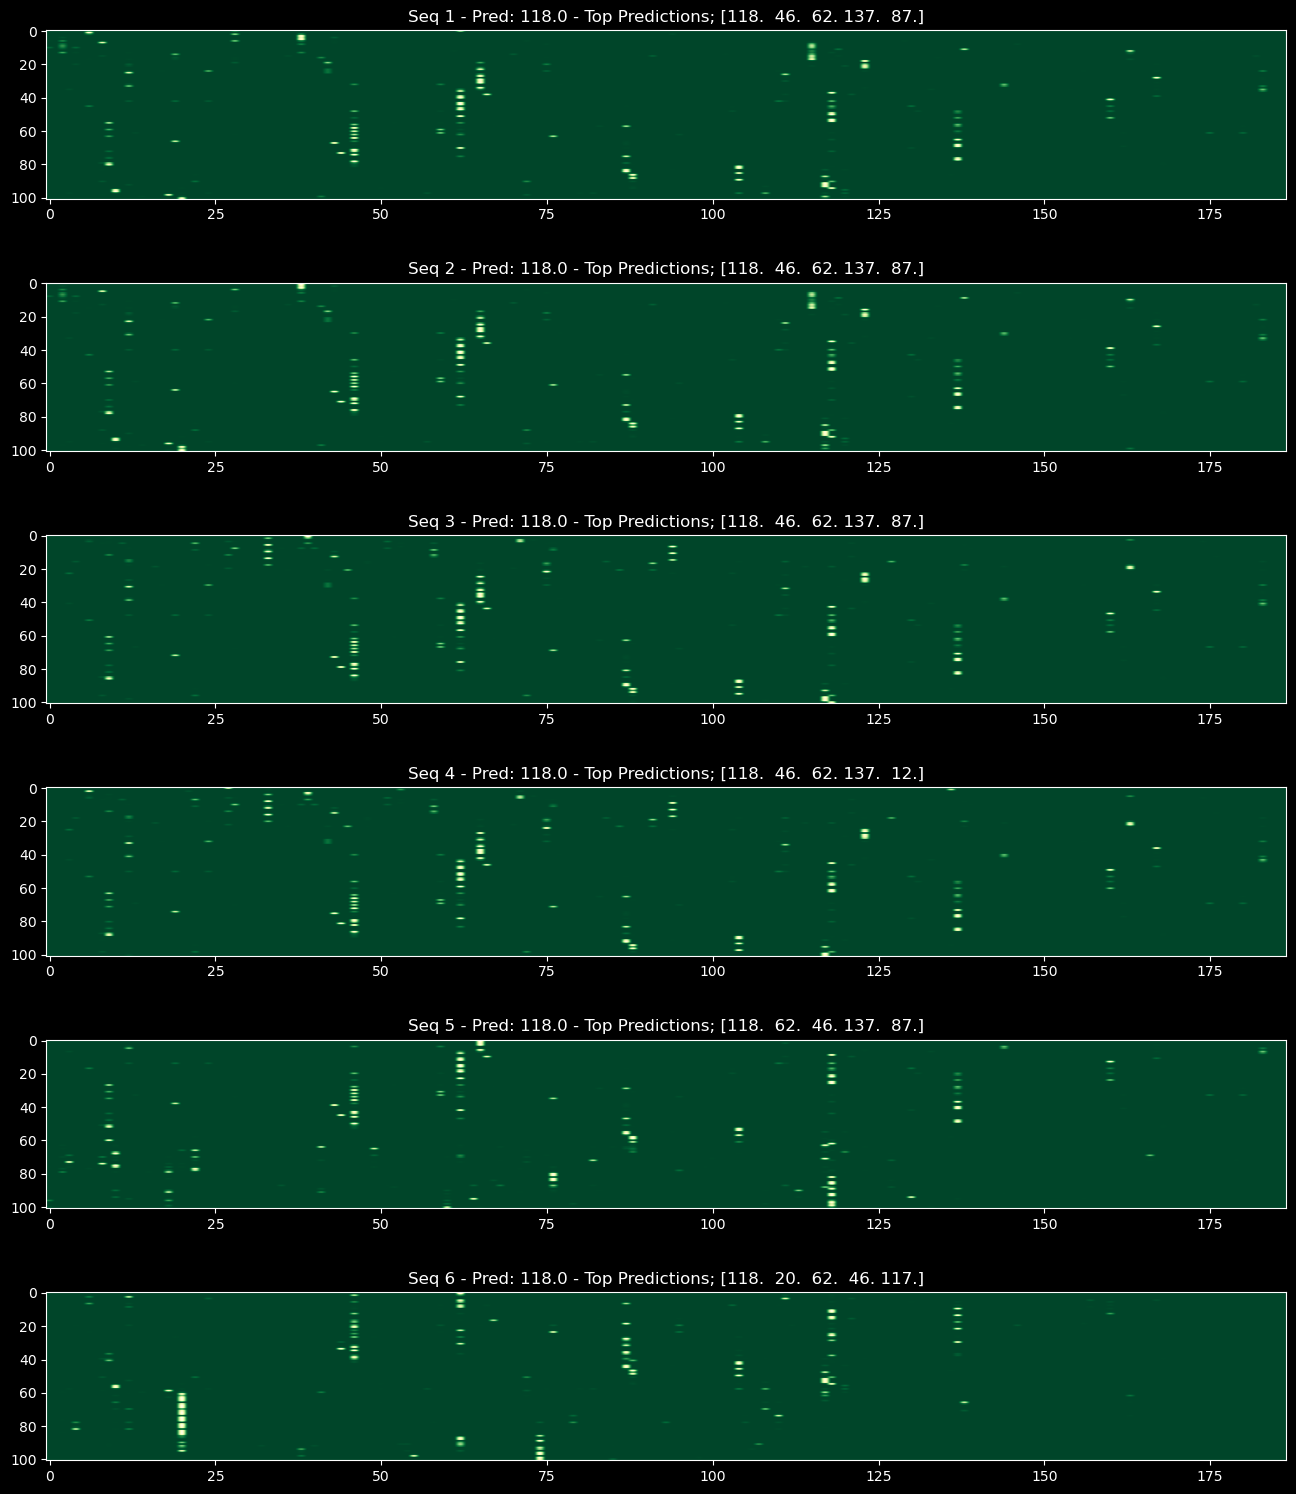

In [65]:
first_seq = 0
nb_seq = 25
s = slice(first_seq, first_seq + nb_seq)

plot_label_probs(probs_per_kmer[correct_pred_idxs][s,:,:], top_preds[correct_pred_idxs][s], [118])

#### False Positive Only

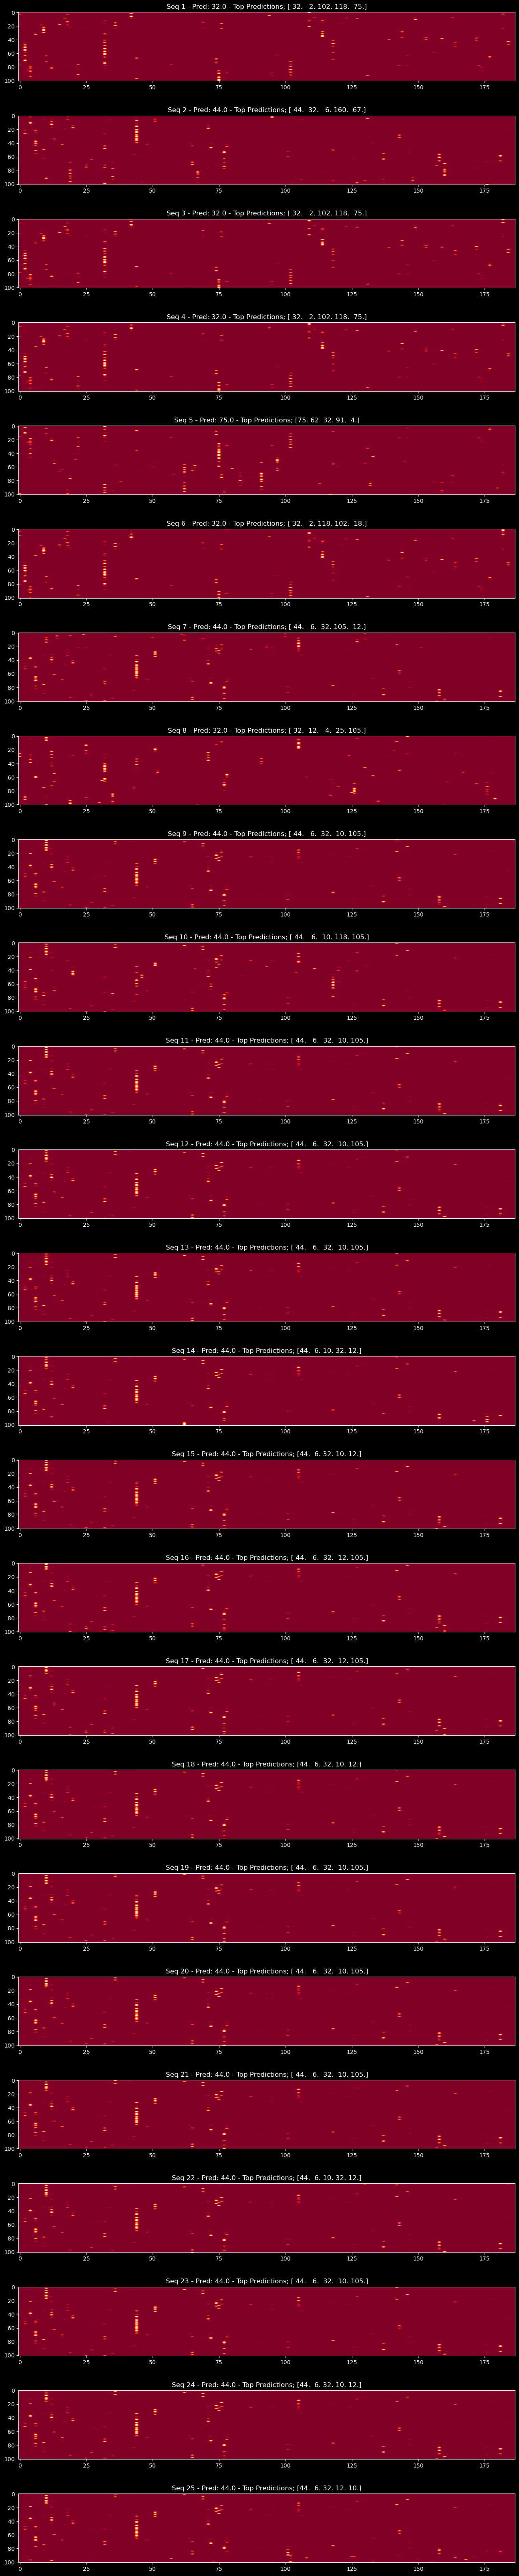

In [67]:
first_seq = 0
nb_seq = 25
s = slice(first_seq, first_seq+nb_seq)

plot_label_probs(probs_per_kmer[incorrect_pred_idxs][s,:,:], top_preds[incorrect_pred_idxs][s], [118])

# New Section

## end of section